In [121]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.float_format","{:.3f}".format)

In [122]:
from sklearn.datasets import make_classification

In [123]:
n_seeds_trial = 10

In [124]:
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=3, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=2, 
    n_clusters_per_class=3, 
    weights=None, 
    flip_y=0.01, 
    class_sep=1.0,
    hypercube=True,
    shift=0.0,
    scale=1.0,
    shuffle=False,
    random_state=2020)

In [125]:
df = pd.DataFrame(X)
df.columns = ["feature_" + str(col) for col in df.columns]
df["target"] = y

In [126]:
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target
0,0.728,0.519,-1.190,0.379,-0.728,-2.444,-2.333,-0.888,-1.222,0.031,...,0.163,2.503,0.089,0.513,0.381,1.238,-0.398,0.799,-0.576,0
1,0.638,1.541,-2.292,1.864,-0.453,0.263,1.344,0.138,0.106,0.599,...,0.022,-0.746,-1.226,-1.281,-2.477,-1.168,0.082,0.020,-0.201,0
2,1.130,0.019,0.231,-0.211,-1.146,0.667,1.113,1.976,-0.197,0.140,...,0.014,-1.018,0.783,-1.218,-1.918,-0.867,-1.993,0.729,-2.003,0
3,1.953,-0.384,0.908,-0.706,0.761,0.252,-1.770,-0.522,-0.716,-0.532,...,-1.764,-0.548,0.793,0.463,1.880,-0.187,0.433,0.181,1.528,0
4,0.774,0.296,0.043,1.660,-1.367,1.029,-0.196,1.056,-0.453,-0.395,...,1.344,1.518,-0.554,1.552,1.388,-1.182,-0.961,0.331,-0.565,0


In [127]:
cols = [col for col in df.columns if col not in ["target"]]
kf = KFold(n_splits = 5,random_state = 2020)

In [128]:
param = {"objective":"binary",
         "learning_rate": 0.1,
         "metric": "auc"
        }

In [129]:
param["feature_fraction"] = 1.0

feature_importance_df_10 = pd.DataFrame()

for seed in range(n_seeds_trial):
    param["feature_fraction_seed"] = seed
    
    for fold, (idx_tr, idx_te) in enumerate(kf.split(df)):
    
        trn_data = lgb.Dataset(df.iloc[idx_tr][cols], label=df.iloc[idx_tr]["target"])
        val_data = lgb.Dataset(df.iloc[idx_te][cols], label=df.iloc[idx_te]["target"])

        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 100)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = cols
        fold_importance_df["importance"] = clf.feature_importance(importance_type = "gain")
        fold_importance_df["seed"] = seed
        fold_importance_df["fold"] = fold + 1
        feature_importance_df_10 = pd.concat([feature_importance_df_10, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.967006	valid_1's auc: 0.58502
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	training's auc: 0.984778	valid_1's auc: 0.949258
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[43]	training's auc: 0.990035	valid_1's auc: 0.907166
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4]	training's auc: 0.964104	valid_1's auc: 0.902604
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[885]	training's auc: 1	valid_1's auc: 0.698563
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.967006	valid_1's auc: 0.58502
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[45]	tra

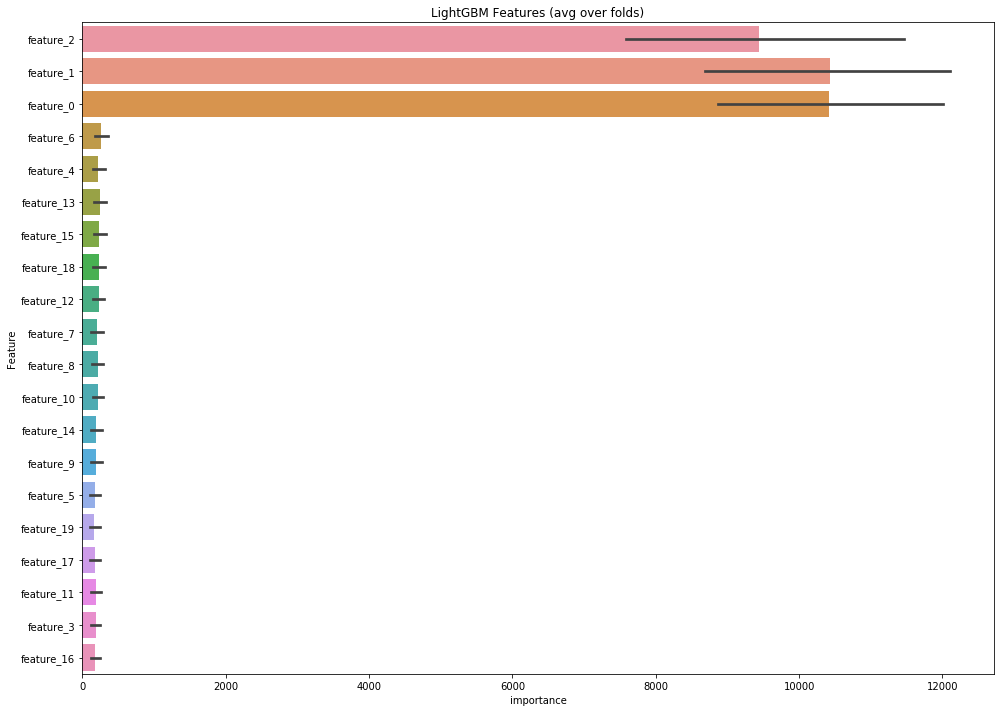

In [130]:
plt.figure(figsize=(14,10))
sns.barplot(x="importance",
            y="Feature",
            data=feature_importance_df_10.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [131]:
param["feature_fraction"] = 0.5

feature_importance_df_05 = pd.DataFrame()

for seed in range(n_seeds_trial):
    param["feature_fraction_seed"] = seed
    
    for fold, (idx_tr, idx_te) in enumerate(kf.split(df)):
    
        trn_data = lgb.Dataset(df.iloc[idx_tr][cols], label=df.iloc[idx_tr]["target"])
        val_data = lgb.Dataset(df.iloc[idx_te][cols], label=df.iloc[idx_te]["target"])

        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 100)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = cols
        fold_importance_df["importance"] = clf.feature_importance(importance_type = "gain")
        fold_importance_df["seed"] = seed
        fold_importance_df["fold"] = fold + 1
        feature_importance_df_05 = pd.concat([feature_importance_df_05, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	training's auc: 0.937958	valid_1's auc: 0.556852
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	training's auc: 0.97256	valid_1's auc: 0.953021
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[344]	training's auc: 1	valid_1's auc: 0.894439
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	training's auc: 0.991338	valid_1's auc: 0.885778
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.963463	valid_1's auc: 0.860047
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.960526	valid_1's auc: 0.634095
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	tr

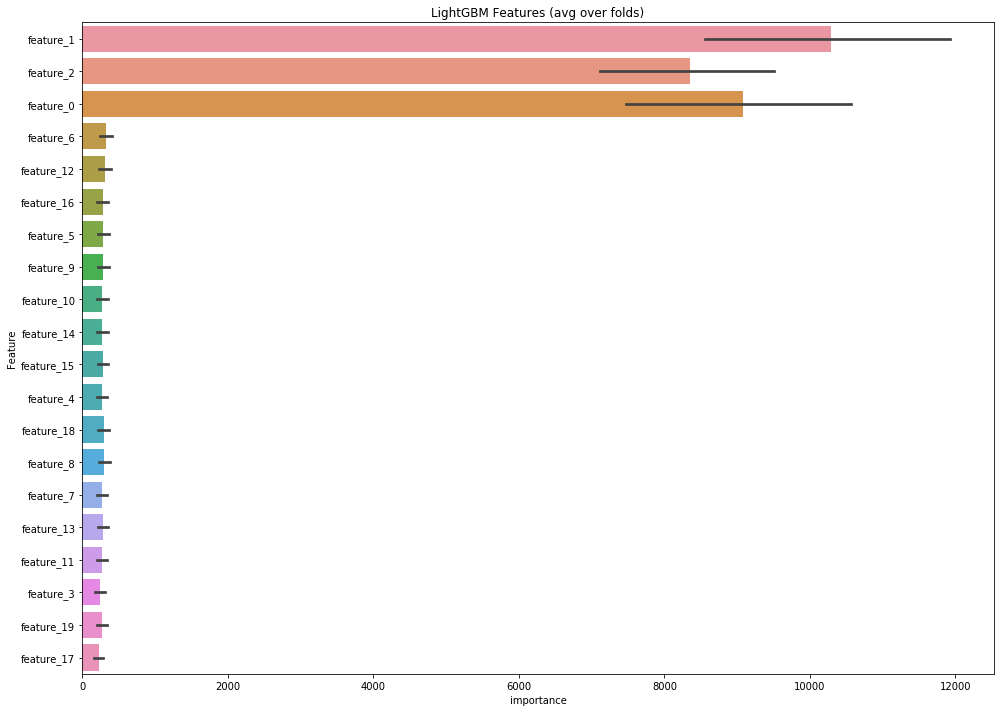

In [132]:
plt.figure(figsize=(14,10))
sns.barplot(x="importance",
            y="Feature",
            data=feature_importance_df_05.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [133]:
param["feature_fraction"] = 0.1

feature_importance_df_01 = pd.DataFrame()

for seed in range(n_seeds_trial):
    param["feature_fraction_seed"] = seed
    
    for fold, (idx_tr, idx_te) in enumerate(kf.split(df)):
    
        trn_data = lgb.Dataset(df.iloc[idx_tr][cols], label=df.iloc[idx_tr]["target"])
        val_data = lgb.Dataset(df.iloc[idx_te][cols], label=df.iloc[idx_te]["target"])

        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 100)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = cols
        fold_importance_df["importance"] = clf.feature_importance(importance_type = "gain")
        fold_importance_df["seed"] = seed
        fold_importance_df["fold"] = fold + 1
        feature_importance_df_01 = pd.concat([feature_importance_df_01, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.739295	valid_1's auc: 0.629298
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[111]	training's auc: 0.959948	valid_1's auc: 0.906187
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's auc: 0.545943	valid_1's auc: 0.512021
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[141]	training's auc: 0.9743	valid_1's auc: 0.666856
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's auc: 0.979502	valid_1's auc: 0.630265
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	training's auc: 0.890678	valid_1's auc: 0.615803
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:

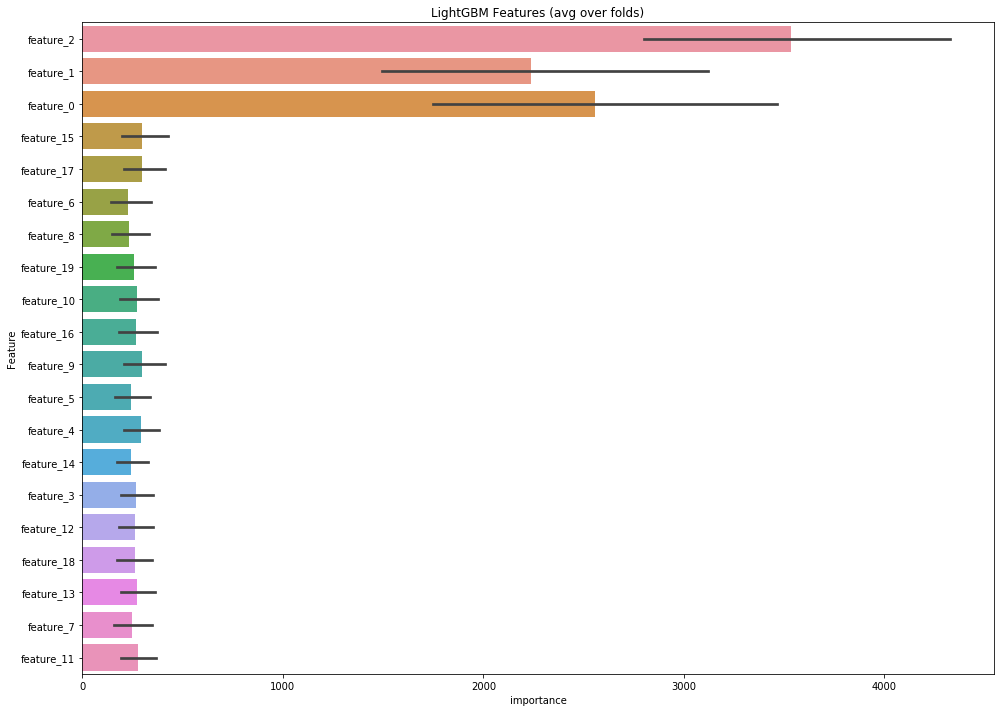

In [134]:
plt.figure(figsize=(14,10))
sns.barplot(x="importance",
            y="Feature",
            data=feature_importance_df_01.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [135]:
feature_importance_df_10["fraction"] = "fraction_1.0"
feature_importance_df_05["fraction"] = "fraction_0.5"
feature_importance_df_01["fraction"] = "fraction_0.1"

In [136]:
df_frac = pd.concat([feature_importance_df_10, feature_importance_df_05, feature_importance_df_01], axis = 0).reset_index()

In [137]:
df_frac.sort_values(by = "fraction", ascending = False).head()

,index,Feature,importance,seed,fold,fraction
0,0,feature_0,910.074,0,1,fraction_1.0
672,12,feature_12,0.000,6,4,fraction_1.0
659,19,feature_19,98.171,6,3,fraction_1.0
660,0,feature_0,7365.171,6,4,fraction_1.0
661,1,feature_1,7120.812,6,4,fraction_1.0


In [138]:
df_frac["importance"] = df_frac["importance"].astype(float)

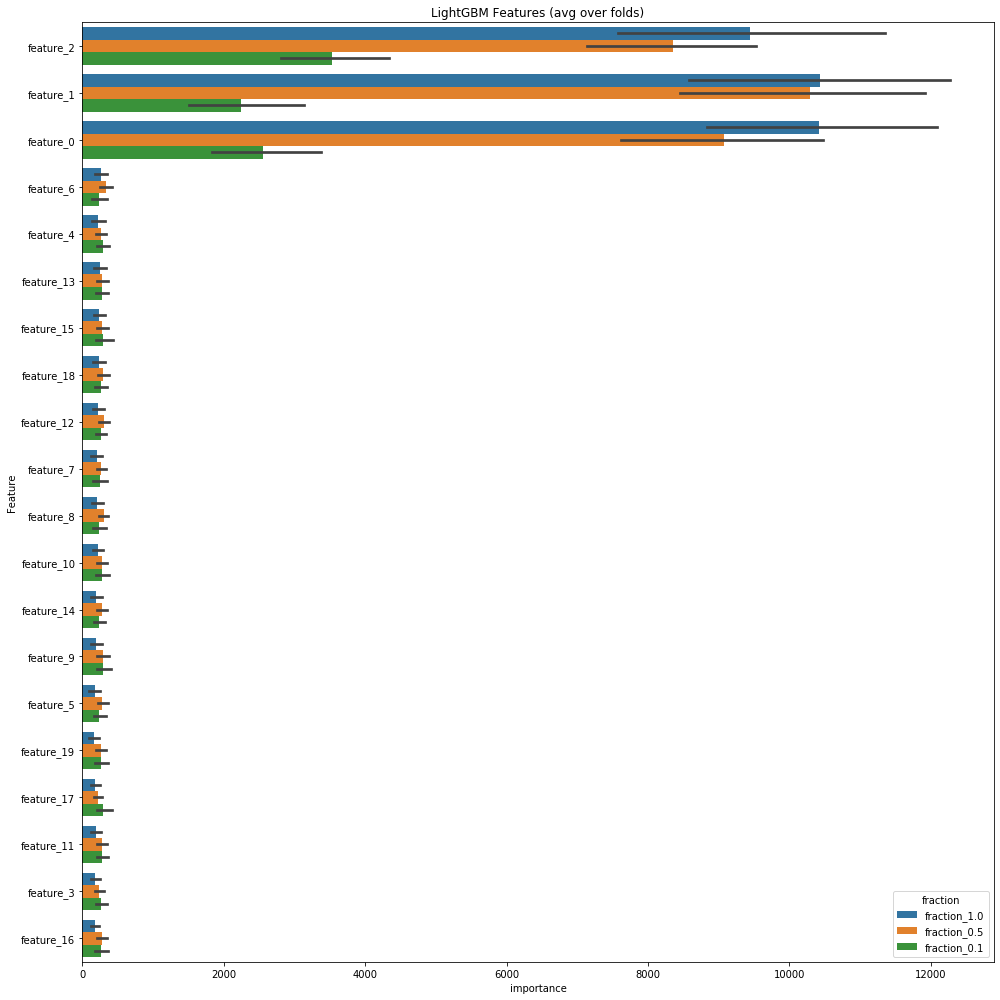

In [139]:
plt.figure(figsize=(14,14))
sns.barplot(x="importance",
            y="Feature",
            hue = "fraction",
            data=df_frac.sort_values(by=["fraction", "importance"],
                                           ascending=[False, False]))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

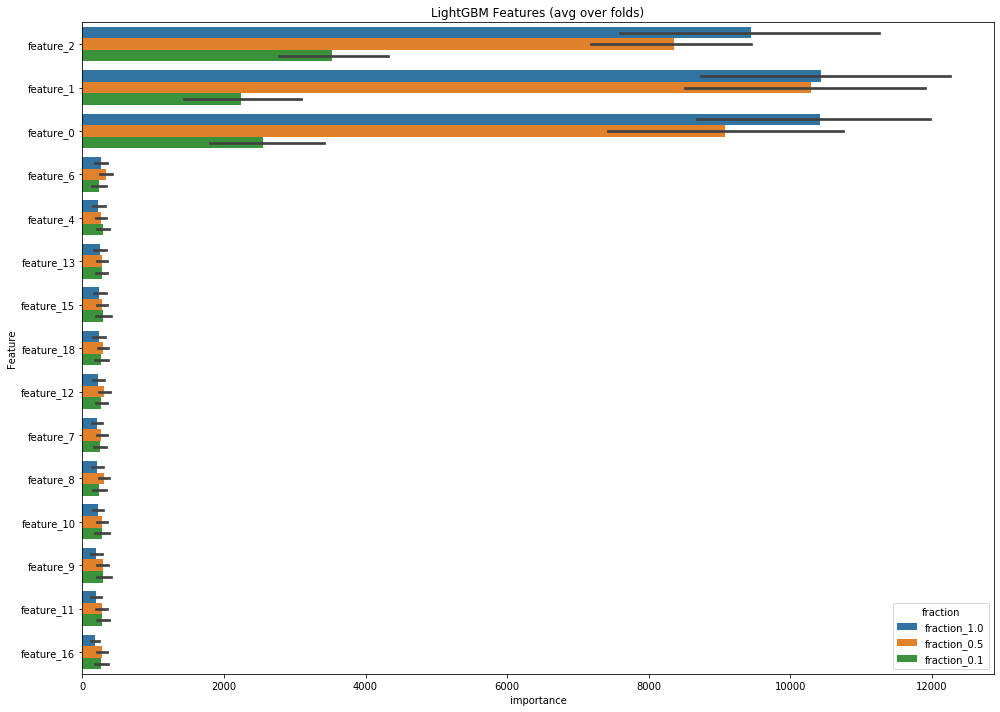

In [140]:
features_high = df_frac.groupby(["Feature"])["importance"].mean().sort_values(ascending = False).head(15).index.tolist()

plt.figure(figsize=(14,10))
sns.barplot(x="importance",
            y="Feature",
            hue = "fraction",
            data=df_frac[df_frac["Feature"].isin(features_high)].sort_values(by=["fraction", "importance"],
                                           ascending=[False,False]))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [141]:
features_zero = df_frac.groupby(["fraction","Feature"])["importance"].mean().reset_index()
features_zero = features_zero[features_zero["importance"] == 0]["Feature"].unique().tolist()
df_frac[df_frac["Feature"].isin(features_zero)].groupby(["Feature", "fraction"])["importance"].mean().reset_index()

,Feature,fraction,importance


In [142]:
df_frac = df_frac[["Feature","importance","seed","fold","fraction"]]

In [143]:
df_frac["importance"] = df_frac["importance"].astype(float)

In [144]:
df_frac.head()

,Feature,importance,seed,fold,fraction
0,feature_0,910.074,0,1,fraction_1.0
1,feature_1,2627.331,0,1,fraction_1.0
2,feature_2,2485.881,0,1,fraction_1.0
3,feature_3,0.000,0,1,fraction_1.0
4,feature_4,0.000,0,1,fraction_1.0


In [145]:
df_mean = df_frac.groupby(["Feature","fraction"])["importance"].mean().reset_index()

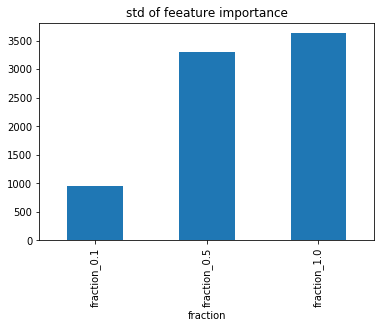

In [146]:
df_mean.groupby(["fraction"])["importance"].std().plot(kind = "bar", title = "std of feeature importance");

In [147]:
# df_frac.to_csv("../input/df_frac_synthe.csv", index = False)

In [148]:
# sns.pairplot(df);